<a href="https://colab.research.google.com/github/catebarry/xai-assignments/blob/main/assignment-1/interpretable_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 1: Interpretable ML
### Catie Barry


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catebarry/xai-assignments/blob/main/assignment-01.ipynb)

# Description
In this notebook, we are working with a dataset from a telecommunications company (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code). The company wants to understand the factors that contribute to customer churn and develop interpretable models to predict which customers are at risk of churning.

We will first do an exploratory data analysis to check for assumptions. Then, we will create a linear regression model, a logistic regression model, and a GAM model. Finally, we will compare the performance and interpretability of the different models and provide a recommendation for the company.

**SOURCES:** Inspiration from Dr. Brinnae Bent's interpretable ml examples in the Duke-AI-XAI repo (https://github.com/AIPI-590-XAI/Duke-AI-XAI/tree/main/interpretable-ml-example-notebooks) and coding assistance to create models and evaluations from ChatGPT 5.0 (specific citations throughout in comments).

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "xai-assignments" # Change to your repo name
git_path = 'https://github.com/catebarry/xai-assignments.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'assignment-1/requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'assignment-1'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'xai-assignments' already exists and is not an empty directory.
/content/xai-assignments/assignment-1
data/  interpretable-ml.ipynb  requirements.txt


In [ ]:
# installations

!pip install pygam --quiet

In [ ]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from pygam import LogisticGAM, s
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Exploratory Data Analysis

We begin by exploring the Telco Customer Churn dataset to understand its structure, distributions, and potential issues that might violate assumptions.

In this section, we will:
- Load and clean the dataset
- Explore the target variable (Churn) and class balance
- Visualize numeric and categorical features
- Identify potential violations of linear, logistic, and GAM model assumptions (for the assumptions that we can check before modeling)

NOTE: Some assumptions require residuals and will be fully tested later, once we fit regression models.

### 1. Load and Inspect the Dataset

The [Telco Customer Churn dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) contains 7,043 rows (customers) and 21 columns (features + target). It has info such as customer demographics, account information, service usage, billing details, and whether the customer churned (`Churn`).
- **customerID** is a unique identifier (string).  
- Most variables are **categorical (object type)**, such as `gender`, `Contract`, and `PaymentMethod`.  
- A few are **numeric**:  
  - `tenure` (integer, number of months as a customer)  
  - `MonthlyCharges` (float, monthly bill amount)  
  - `TotalCharges` (string, should be numeric but contains some non-numeric blanks)  
- The target variable **Churn** is categorical (`Yes`/`No`).  

➡️ Cleaning steps required:  
- Convert `Churn` to binary (Yes = 1, No = 0).  
- Convert `TotalCharges` to numeric and handle blanks.  


In [ ]:
# load dataset
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# inspect
print(f"Dimensions: {df.shape}")

df.info()
df.head()

Dimensions: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

There aren't any missing/null or duplicate values in the dataset.

### 2. Target Variable and Data Cleaning

- `Churn`: convert Yes → 1, No → 0  
- `TotalCharges`: currently stored as `object` (string), needs conversion to numeric. Some values are blank and will be replaced with the median.  

In [ ]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370
std,0.368612,24.559481,30.090047,2266.771362,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


TotalCharges is set to NaN for 11 customers, all with tenure of 0 (new customers). We can fill in the total charges with the current monthly charges, as their charges have not yet been accounted for in total charges.

In [ ]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [ ]:
description = df.describe()
description.loc['mode'] = df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
print(description)

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges        Churn
count    7043.000000  7043.000000     7043.000000   7043.000000  7043.000000
mean        0.162147    32.371149       64.761692   2279.798992     0.265370
std         0.368612    24.559481       30.090047   2266.730170     0.441561
min         0.000000     0.000000       18.250000     18.800000     0.000000
25%         0.000000     9.000000       35.500000    398.550000     0.000000
50%         0.000000    29.000000       70.350000   1394.550000     0.000000
75%         0.000000    55.000000       89.850000   3786.600000     1.000000
max         1.000000    72.000000      118.750000   8684.800000     1.000000
mode        0.000000     1.000000       20.050000     20.200000     0.000000


The data is skewed for numeric features.

### 3. Churn Class Balance

We check whether churned vs. non-churned customers are balanced.

➡️ This plot shows a slight **class imbalance**, which is important for modeling: accuracy alone may be misleading if a model just predicts “No churn” most of the time.  

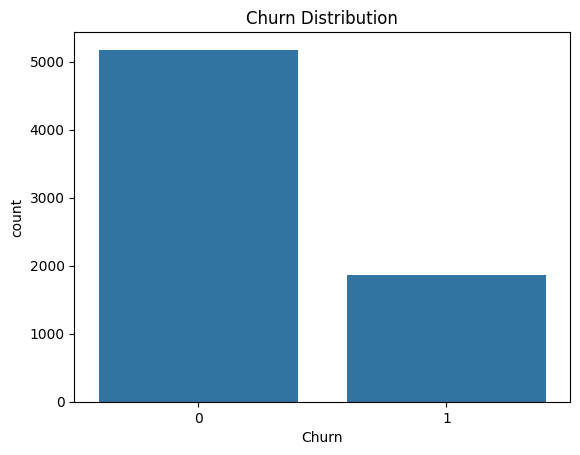

In [ ]:
# class balance
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

### 4. Distribution of Numeric Features

We examine `tenure`, `MonthlyCharges`, and `TotalCharges` to check for skewness and potential outliers.

- **tenure**: Many customers are recent (low tenure), with visible spikes at contract renewal points every 12 months. There are also significantly more customers at the extremes: many have either very low (new customers) or very high tenure (old customers).
- **MonthlyCharges**: Fairly evenly spread from low to high, with significant peak at lower end. (Ingorning the peak, monthly charges tend to be left skewed.)  
- **TotalCharges**: Right-skewed — many customers have low total charges (short tenure), while a smaller number have very high totals.  

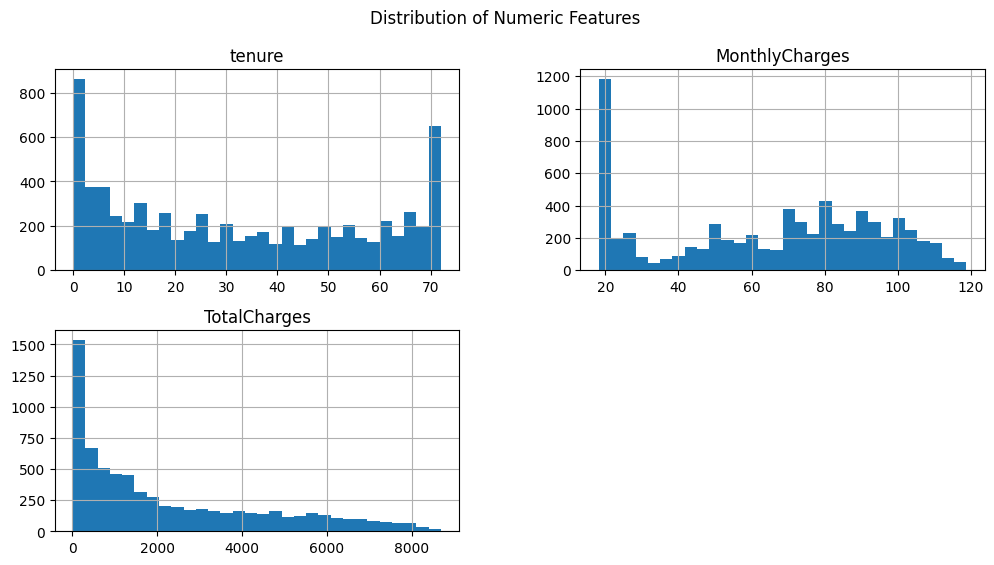

In [ ]:
# univariate analysis
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[num_features].hist(bins=30, figsize=(12,6))
plt.suptitle("Distribution of Numeric Features")
plt.show()

### 5. Numeric Features vs. Churn (Linearity Preview)

Boxplots show whether churn differs across numeric features.  
This gives an early view of potential non-linearities.

Interpretation:  
- Customers with short tenure churn more often
  - There appear to be several outliers, where customers with very high tenure churn more often
- Customers with high MonthlyCharges churn more often
- Churned customers have much lower total charges (because they left earlier)
  - There appear to be a signifcant number of outliers, where customers with very high total charges churn more often

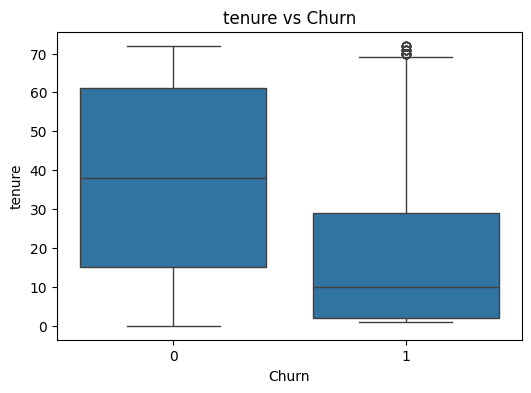

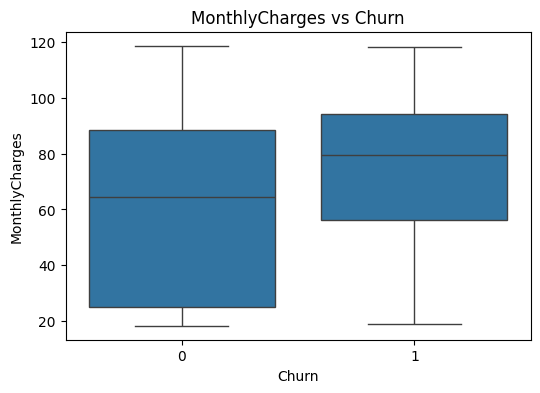

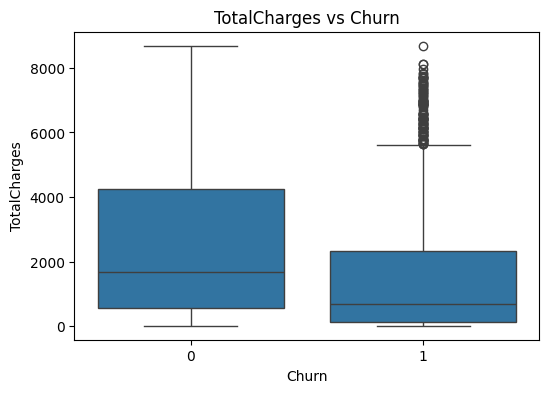

In [ ]:
# churn vs numeric features
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()

### 6. Categorical Features vs. Churn

We check whether churn varies across demographic and account categories.

Based on observations of graphs:
- Partner: customers with partners churn less often
- Dependents: customers with dependents churn less often
- InternetService: fiber optic customers churn more often
- OnlineSecurity: customers with no online secruity churn more often
- OnlineBackup: customers with no online backup churn more often
- DeviceProtection: customers with no device protection churn more often
- TechSupport: customers with no tech support churn more often
- Contract: customers on month-to-month contracts churn much more often
- PaperlessBilling: customers with paperless billing churn more often
- PaymentMethod: electronic check users churn more often
- Other features (including Gender, SeniorCitizen, PhoneService, MultipleLines, StreamingTV, StreamingMovies) appear to have no or little meaningful difference on churn rates

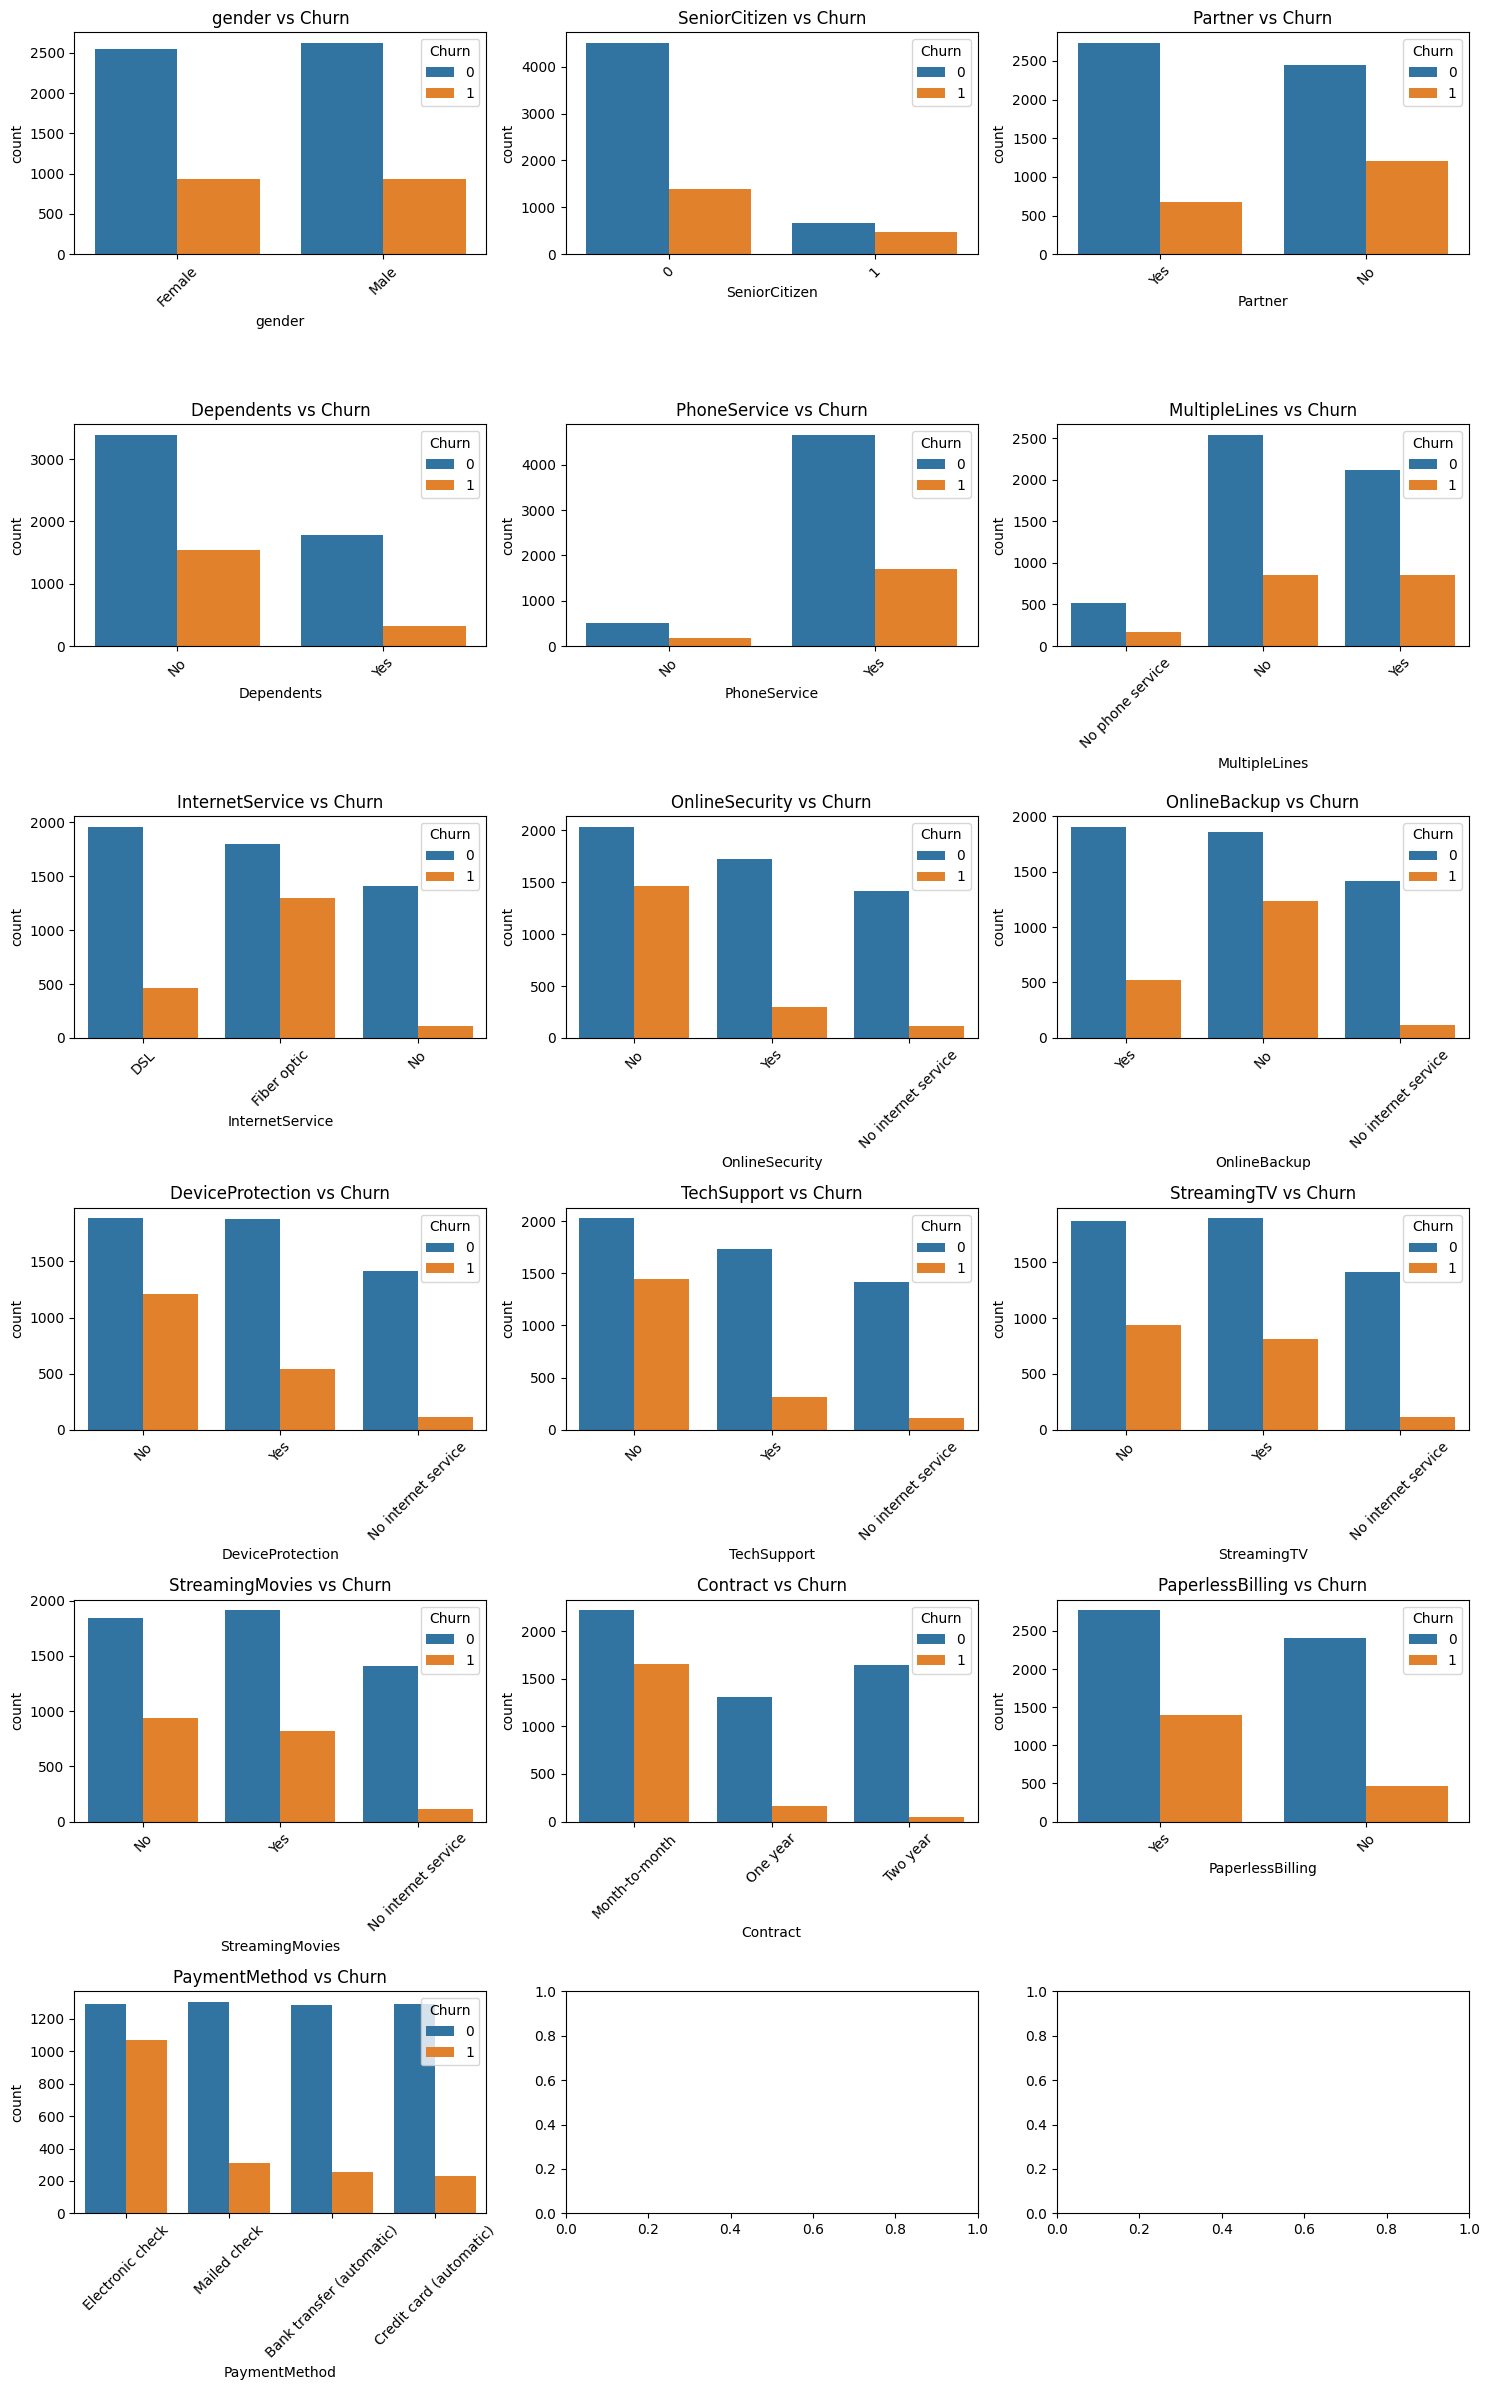

In [ ]:
cat_features = ['gender','SeniorCitizen','Partner','Dependents','PhoneService',
                'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
                'Contract','PaperlessBilling','PaymentMethod']

# set up grid
n = len(cat_features)
rows = math.ceil(n/3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 4*rows))

for i, col in enumerate(cat_features):
    r, c = divmod(i, 3)
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[r][c])
    axes[r][c].set_title(f"{col} vs Churn")
    axes[r][c].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 7. Correlation Analysis

We compute correlations among numeric and binary features to check for multicollinearity, which can negatively affect linear regression models. Highly correlated predictors may provide redundant information.

We encoded binary variables (No mapped to 0, Yes mapped to 1). We could also encode categorical variables with >2 categories using one hot encoding, but

Interpretation:  
- `TotalCharges` and `tenure` are strongly correlated
- `MonthlyCharges` is moderately correlated with `TotalCharges`
- `Dependents` is slightly correlated with `Partner`
- Correlations with **Churn** are relatively weak individually, suggesting churn depends on multiple factors combined

In [ ]:
# Columns with object dtype (strings)
categorical_cols = df.select_dtypes(include=['object']).columns

# Exclude ID-like columns
exclude_cols = ['customerID']
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# Keep only binary ones (exactly 2 unique values)
binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]

print("Binary columns:", binary_cols)

Binary columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


In [ ]:
# Define mapping
binary_map = {'Yes': 1, 'No': 0, 'Male': 0, 'Female': 1}

# Apply it
for col in binary_cols:
    df[col] = df[col].map(binary_map)

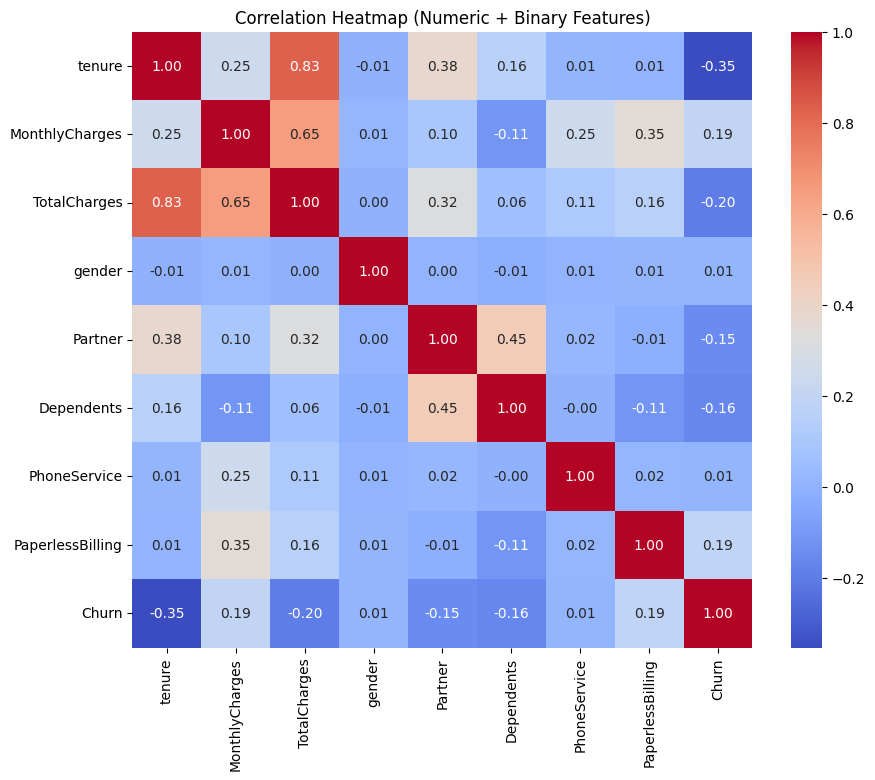

In [ ]:
# correlation matrix including numeric + binary-encoded features
plt.figure(figsize=(10,8))
sns.heatmap(df[num_features + binary_cols + ['Churn']].corr(), annot=True, cmap="coolwarm", fmt=".2f") # this line of code was generated using ChatGPT 5.0 on 9/12/25
plt.title("Correlation Heatmap (Numeric + Binary Features)")
plt.show()


### 8. Outlier Detection (Preview)

In the EDA stage, we can only do a **basic check for extreme values** using boxplots and descriptive statistics.  
Formal influence diagnostics (Cook’s distance, studentized residuals, DFBETAS) will be applied later, after fitting regression models.

- **MonthlyCharges**: A few customers pay near the maximum (\$120+), which appear as high-end outliers.  
- **TotalCharges**: Some customers have very large totals (\$8,000–\$9,000+), reflecting long tenure and high monthly charges. These are valid but extreme.  
- **tenure**: No extreme outliers, naturally capped at 72 months.  

➡️ These preliminary checks suggest some extreme values exist, but further testing will determine if they unduly influence regression models.

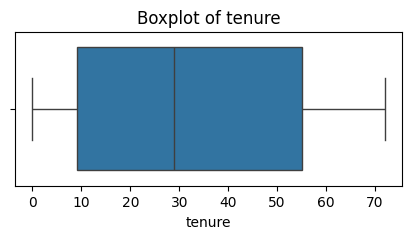

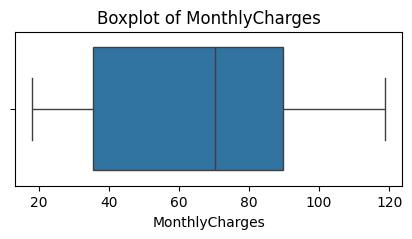

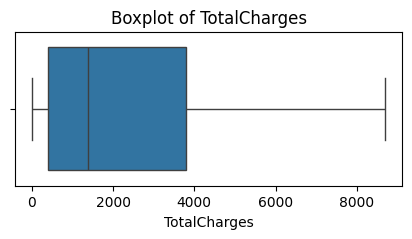

In [ ]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_features:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

### 9. Assumption Checks Summary

**Linearity**:
- Applies to: linear regression (predictors vs. outcome), logistic regression (predictors vs log odds), NOT required for GAM (since allows smooth nonlinear terms)
- For linear regression, because Churn is binary, the assumption is met by default. ✅
- For logistic regression, the relationship is between predictors and the log-odds of churn--we'll revisit later. ⚠️

**Independence of Observations**:
- Applies to: all models
- Customers are distinct/independent, so assumption holds. ✅

**Homoscedasticity**:
- Applies to: linear regression
- To be tested later using residuals. ⚠️

**No multicollinearity**:
- Applies to: all models
- Some correlation present between features, so we may need feature selection or regularization (see correlation analysis; will revisit later). ❌

**Normality of residuals**:
- Applies to: linear regression
- Residual normality to be tested later. ⚠️

**No influential outliers**:
- Applies to: linear & logistic regression
- Revisit later with Cook's distance / leverage plots. ⚠️

**No autocorrelation**:
- Applies to: linear regression
- Not relevat here, as data is cross-sectional (not time-series) ✅

**No endogeneity**:
- Applies to: linear & logistic regression
- Assume this holds because dataset is observational and well-structured ✅

**Correct specification**:
- Applies to: linear & logsitc regression
- To check later ⚠️

**Absence of Perfect Separation:**
- Applies to: logistic regression, GAM
- Contingency tables and plots confirm no predictor perfectly predicts churn ✅

**Large sample size:**
- Applies to: logistic regression
- Dataset has sufficient observations ✅

➡️ We will revisit assumptions requiring residuals during model fitting (linear, logistic, GAM).

# Linear Regression
 We treated churn as a continuous variable (0 = no churn, 1 = churn) and fit a linear regression model to predict churn. We then interpreted the coefficients and assessed the model's performance.

### 1. Data Prep

#### Encoding Categorical Variables

- The target variable `Churn` was mapped to binary: Yes = 1, No = 0
- Binary categories (Parnter, Dependents, etc.) already mapped to 0/1
- All other categorical features one-hot encoded
  - For multi-category variables (e.g., `Contract`, `PaymentMethod`, `InternetService`), this creates multiple dummy columns, with one category dropped to avoid multicollinearity.  

➡️ This encoding ensures that categorical variables can be used properly in linear, logistic, and GAM models.

In [ ]:
# Drop customerID (not predictive)
df_model = df.drop(columns=['customerID'])

# Separate X (features) and y (target)
X = df_model.drop(columns=['Churn'])
y = df_model['Churn']

# Select only non-binary categorical features
non_binary_features = [col for col in X.select_dtypes(include=['object']).columns
                       if X[col].nunique() > 2] # this line of code was generated using ChatGPT 5.0 on 9/12/25

# One-hot encode only those
X = pd.get_dummies(X, columns=non_binary_features, drop_first=True) # this line of code was generated using ChatGPT 5.0 on 9/12/25

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   MultipleLines_No phone service         7043 non-null   bool   
 10  MultipleLines_Yes                      7043 non-null   bool   
 11  Inte

### 2. Define Evaluate Function

We will use this function to evaluate the linear regression model, using MSE and R2.

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Coefficients
    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    }).sort_values(by="Coefficient", key=abs, ascending=False)

    display(coef_df.head(10))  # show top 10 most important features

    return model, y_pred, coef_df

### 3. Fit Linear Regression Model

In [ ]:
lr_model, lr_pred, coef_df = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
ridge_model, ridge_pred, ridge_coef_df = evaluate_model(Ridge(alpha=1.0), X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression")
lasso_model, lasso_pred, lasso_coef_df = evaluate_model(Lasso(alpha=0.1), X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression")

#print(coef_df)



Linear Regression:
MSE: 0.1341
R2 Score: 0.3109


,Feature,Coefficient
11,InternetService_Fiber optic,0.139810
7,MonthlyCharges,-0.134678
8,TotalCharges,-0.094336
24,StreamingMovies_Yes,0.052323
4,tenure,-0.047045
25,Contract_One year,-0.044255
22,StreamingTV_Yes,0.042991
10,MultipleLines_Yes,0.035257
26,Contract_Two year,-0.034808
28,PaymentMethod_Electronic check,0.033367



Ridge Regression:
MSE: 0.1341
R2 Score: 0.3110


,Feature,Coefficient
11,InternetService_Fiber optic,0.128290
7,MonthlyCharges,-0.106806
8,TotalCharges,-0.094273
24,StreamingMovies_Yes,0.047813
4,tenure,-0.047069
25,Contract_One year,-0.044238
22,StreamingTV_Yes,0.038476
26,Contract_Two year,-0.034785
28,PaymentMethod_Electronic check,0.033367
10,MultipleLines_Yes,0.032952



Lasso Regression:
MSE: 0.1692
R2 Score: 0.1306


,Feature,Coefficient
4,tenure,-0.051036
11,InternetService_Fiber optic,0.030955
28,PaymentMethod_Electronic check,0.010369
1,SeniorCitizen,0.000000
3,Dependents,-0.000000
2,Partner,-0.000000
5,PhoneService,-0.000000
6,PaperlessBilling,0.000000
8,TotalCharges,-0.000000
7,MonthlyCharges,0.000000


### 4. Coefficient Analysis

- Positive coefficients indicate features that increase churn probability:
  - e.g. month-to-month contract, fiber optic internet service
- Negative coefficients indicate features that reduce churn probability:
  - e.g. monthly charges, total charges
- Small coefficients indicate weak linear relationship with target value:
  - e.g. gender

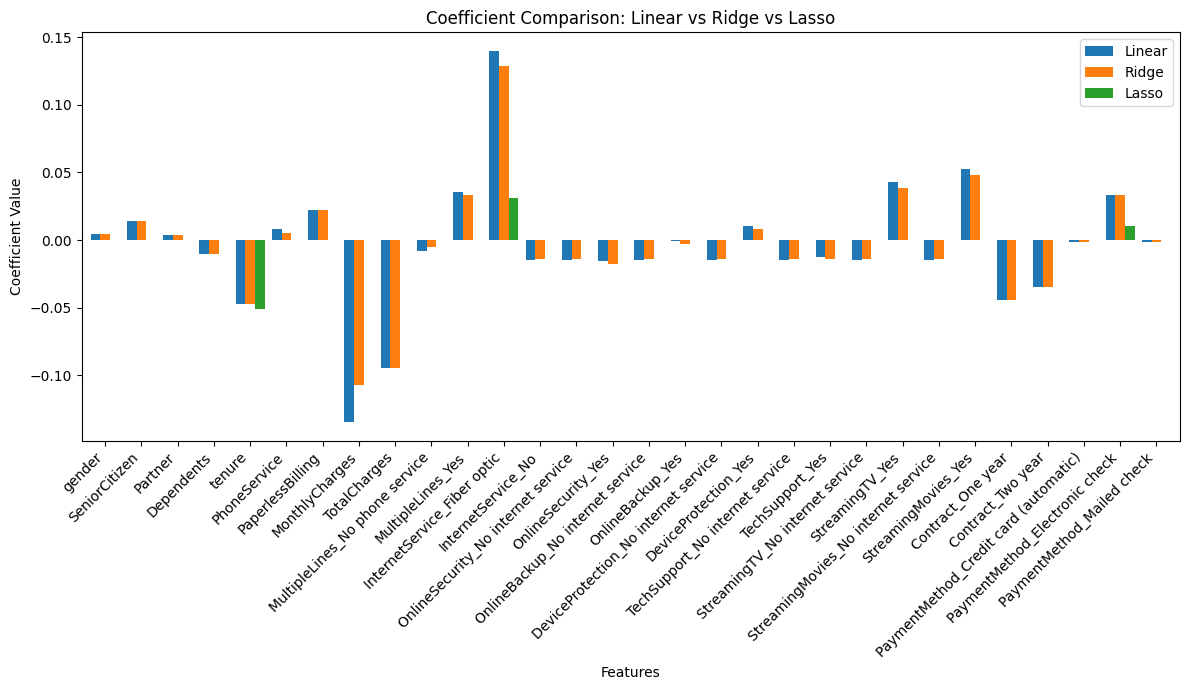

In [ ]:
# coefficient comparison plot
def plot_coefficients(lr_model, ridge_model, lasso_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
        'Ridge': ridge_model.coef_,
        'Lasso': lasso_model.coef_
    }, index=X.columns)

    coef_df.plot(kind='bar', width=0.8, figsize=(12,7))
    plt.title('Coefficient Comparison: Linear vs Ridge vs Lasso')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(lr_model, ridge_model, lasso_model)

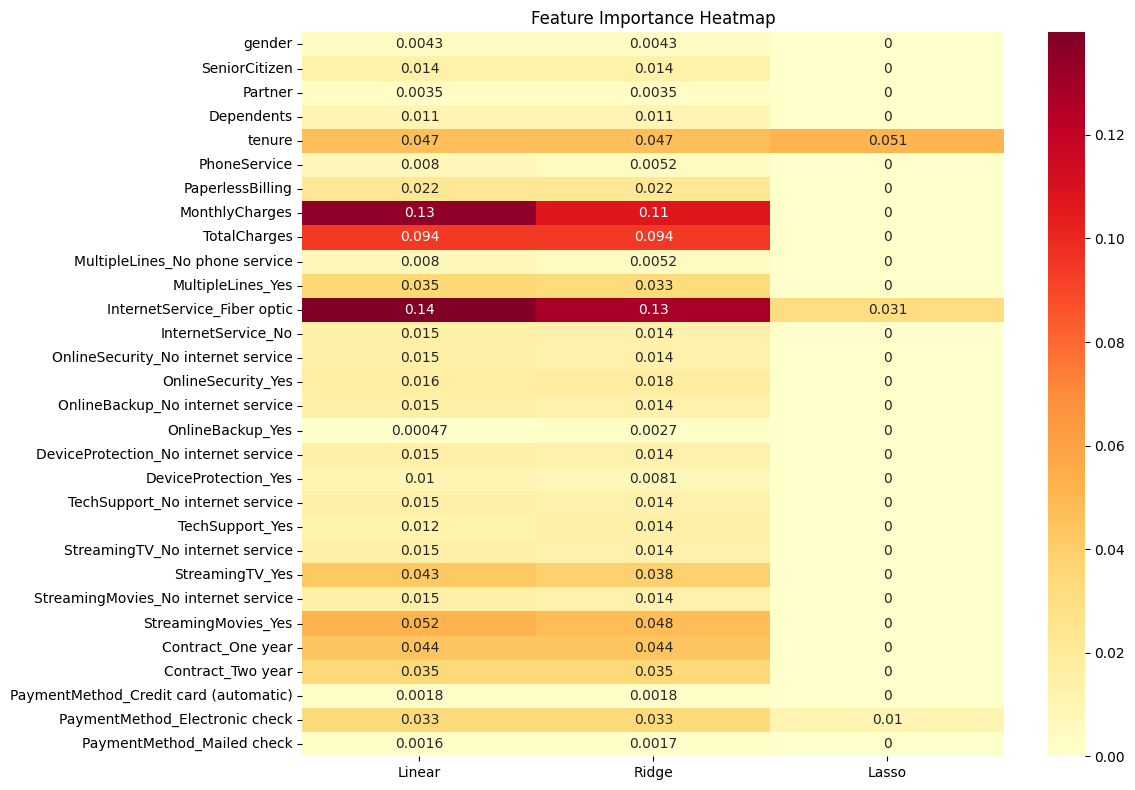

In [ ]:
# Feature Importance Heatmap
# this block of code was generated using ChatGPT 5.0 on 9/12/25
def plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_),
        'Ridge': np.abs(ridge_model.coef_),
        'Lasso': np.abs(lasso_model.coef_)
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model)

### 5. Residual Plot

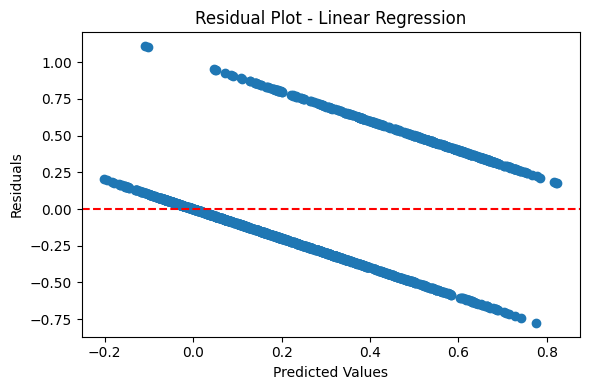

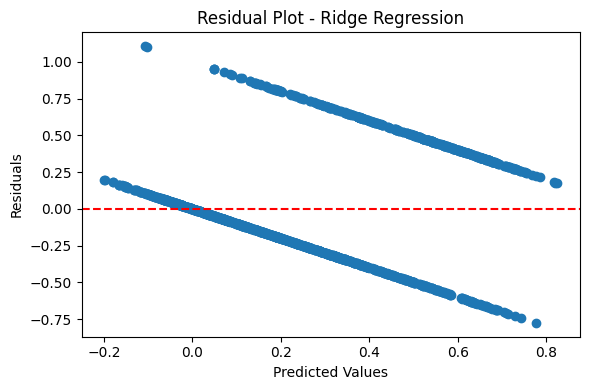

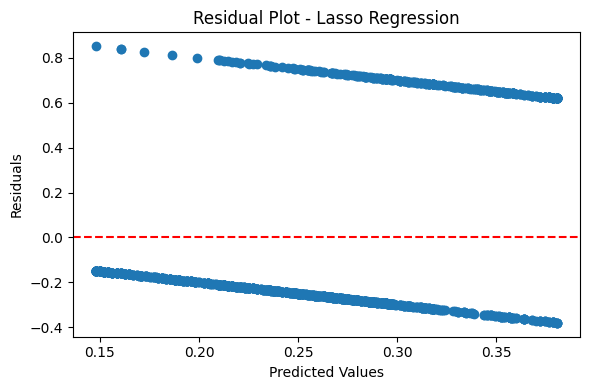

In [ ]:

# Residual Plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, lr_pred, 'Linear Regression')
plot_residuals(y_test, ridge_pred, 'Ridge Regression')
plot_residuals(y_test, lasso_pred, 'Lasso Regression')

### 6. QQ Plot

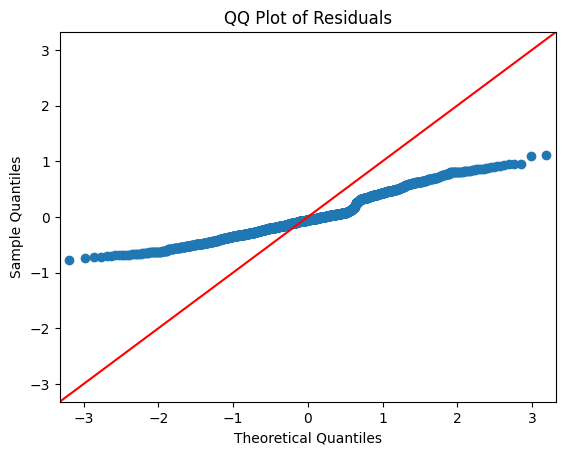

In [ ]:
# QQ plot
residuals = y_test - lr_pred

sm.qqplot(residuals, line='45')
plt.title("QQ Plot of Residuals")
plt.show()

Normality of residuals violated because do not lie on a straight line.

### 7. Actual vs. Predicted Plot

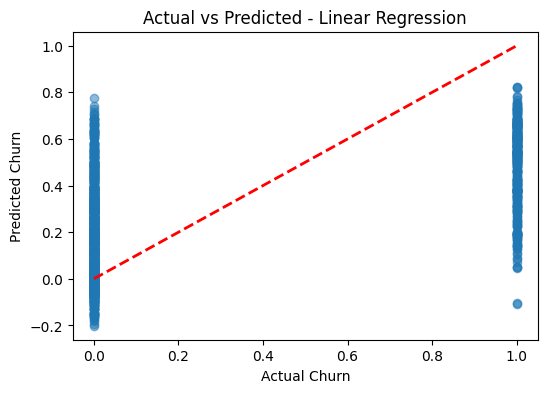

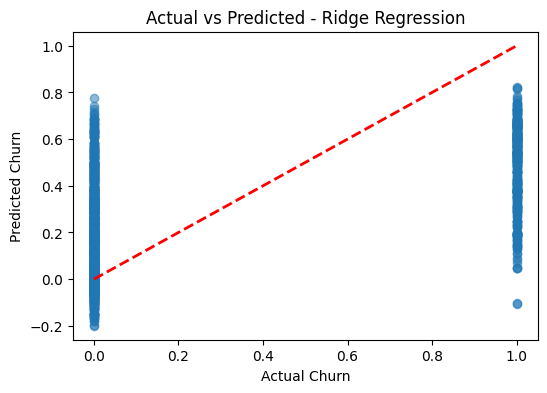

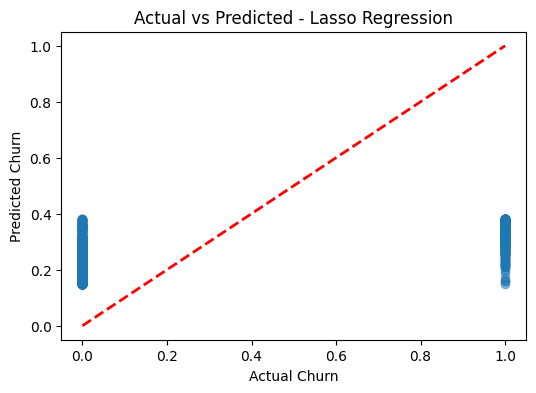

In [ ]:
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([0,1], [0,1], 'r--', lw=2)  # perfect prediction line
    plt.xlabel("Actual Churn")
    plt.ylabel("Predicted Churn")
    plt.title(f"Actual vs Predicted - {model_name}")
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, "Linear Regression")
plot_actual_vs_predicted(y_test, ridge_pred, "Ridge Regression")
plot_actual_vs_predicted(y_test, lasso_pred, "Lasso Regression")

### 8. Interpretation

The linear regression model achieved an R2 of ~0.31, explaining only about 31% of churn variance, and a relatively high MSE of ~0.13. While InternetService (Fiber optic), MonthlyCharges, and TotalCharges were the strongest predictors, the overall fit was weak, which is expected since linear regression is not ideal for a binary target variable.

Residual plots confirmed violations of homoscedasticity and normality assumptions, as residuals clustered around churn categories. QQ plots also showed deviations from normality. Although ridge regression slightly stabilized coefficients, predictive performance did not improve. Lasso regression shrank most coefficients to zero, further lowering model accuracy. These results highlight the limitations of linear regression for churn prediction, reinforcing the need for logistic regression or nonlinear models.

#Logistic Regression
Here, we treat as a binary variable and fit a logistic regression model to predict the probability of churn. We then evaluate the model and interpret the coefficients.

In [ ]:
def evaluate_log_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n{model_name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    #print(f"ROC-AUC:   {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Churn", "Churn"],
                yticklabels=["No Churn", "Churn"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

    coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]}).sort_values('Coefficient', key=abs, ascending=False)

    display(coef_df.head(10))  # top 10 most influential predictors

    return model, y_pred, coef_df


Logistic Regression:
Precision: 0.6862
Recall: 0.5979
Accuracy: 0.8211
F1 Score:  0.6390


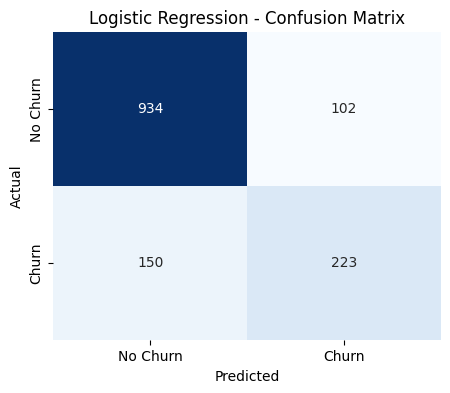


Classification Report:

              precision    recall  f1-score   support

    No Churn       0.86      0.90      0.88      1036
       Churn       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



,Feature,Coefficient
4,tenure,-1.345837
8,TotalCharges,0.646709
7,MonthlyCharges,-0.631823
11,InternetService_Fiber optic,0.621780
26,Contract_Two year,-0.608402
25,Contract_One year,-0.267011
24,StreamingMovies_Yes,0.229481
22,StreamingTV_Yes,0.179870
10,MultipleLines_Yes,0.168958
6,PaperlessBilling,0.163774


In [ ]:
# Fit logistic regression model
log_model = LogisticRegression(max_iter=1000, solver='liblinear')

log_reg_model, log_y_pred, log_coef_df = evaluate_log_model(log_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")


### Interpretation:

The logistic regression model achieved an accuracy of ~82%, with strong performance on the majority “No Churn” class but weaker performance in detecting churners. Precision for churn was 0.69, meaning most churn predictions were correct, but recall was only 0.60, indicating the model missed ~40% of churners. This performance is okay, but can be improved.

Coefficient analysis revealed that longer tenure and long-term contracts are the strongest negative predictors of churn, while having month-to-month contracts, fiber optic service, and certain add-ons (streaming, paperless billing) increase churn risk. These results align with expectations in customer retention: stable, long-term customers are less likely to churn, while high-demand service users may be more volatile. Features with small coeficients have little impact on churn (e.g. gender). Assumption checks showed no severe violations, though multicollinearity may affect interpretation, suggesting regularization could be helpful.

# Generalized Additive Model (GAM)
Finally, we build and interpret a GAM to model the non-linear relationships between customer features and churn.

In [ ]:
def evaluate_gam_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {acc:.4f}")

    return model, y_pred

In [ ]:
# Initialize GAM
gam = LogisticGAM()

# Find best smoothing parameters (gridsearch)
gam.gridsearch(X_train_scaled, y_train)

gam, gam_y_pred = evaluate_gam_model(gam, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic GAM")


100% (11 of 11) |########################| Elapsed Time: 0:01:06 Time:  0:01:06



Logistic GAM:
Precision: 0.6699
Recall: 0.5603
Accuracy: 0.8105


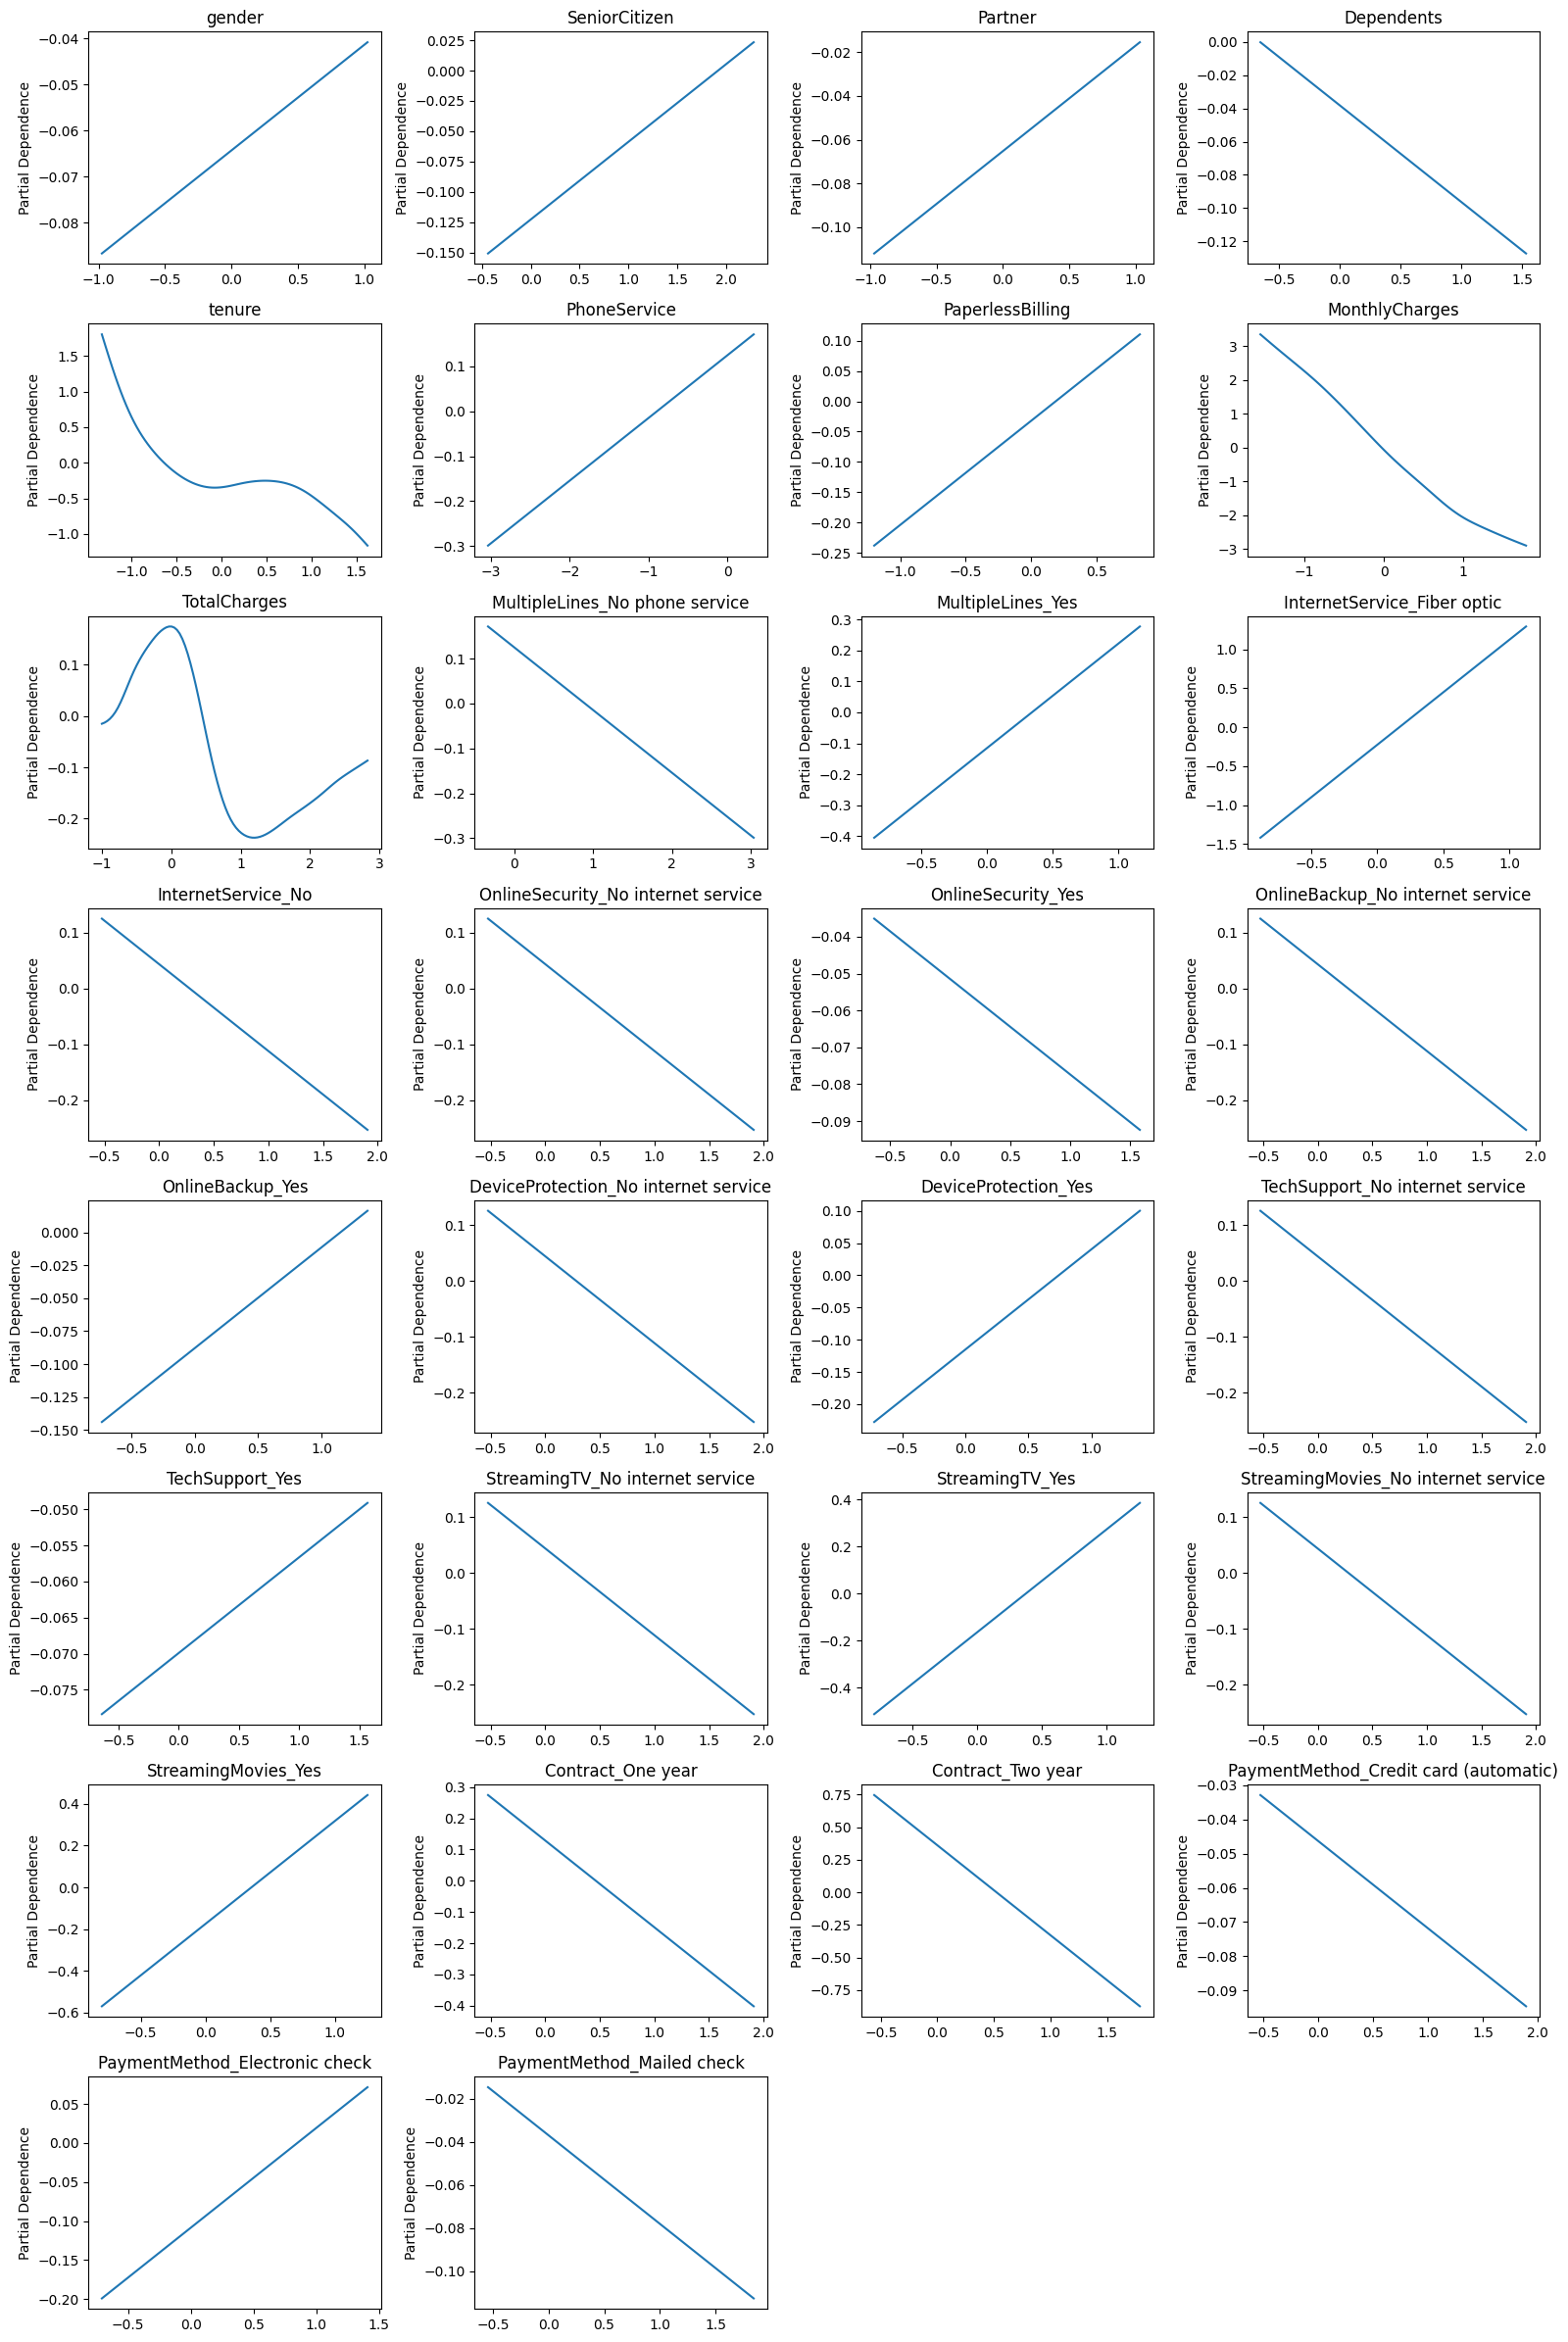

In [ ]:
# Partial dependence plots for each feature
# this block of code was generated using ChatGPT 5.0 on 9/12/25
n_terms = len([t for t in gam.terms if not t.isintercept])  # number of features
n_cols = 4   # how many plots per row
n_rows = math.ceil(n_terms / n_cols)

plt.figure(figsize=(4*n_cols, 3*n_rows))

plot_i = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(n_rows, n_cols, plot_i)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(X.columns[term.feature])
    plt.ylabel("Partial Dependence")
    plot_i += 1

plt.tight_layout()
plt.show()


### Interpretation

The logistic GAM produced results similar to the logistic regression model, with accuracy just over 81%, precision near 67%, and recall around 56%. These scores suggest the model is reasonably good at flagging churn but still misses a notable share of customers who leave. The accuracy looks strong overall, though it should be read with caution because the dataset is imbalanced.

Because GAMs use smooth functions to capture nonlinear feature effects, they are less interpretable compared to the regression models. The partial dependence plots reveal that:
- Tenure has a nonlinear effect, with churn risk falling sharply early on and then flattening, showing that retention improves once customers pass the initial period.
- TotalCharges shows a similar curving trend, consistent with its connection to tenure.
- Contract length still matters: short-term contracts raise churn risk, while longer agreements suppress it.
- Fiber optic service adds risk, similar to findings from simpler models.
- Most other service-related features have smaller, mostly monotonic effects.

Overall, GAM performance is similar to logistic regression, but the model highlights that some relationships aren’t strictly linear. This flexibility helps uncover how predictors like tenure and billing evolve in their influence, giving a richer view of churn dynamics.

# Model Comparison
We compare the performance and interpretability of the different models we built, discussing the strengths and weaknesses of each approach and providing recommendations for which model(s) the telecommunications company should use to address their customer churn problem.

**Linear Regression:**
- Pros: Interpretable, with cofficients that are easy to explain (e.g. feature importance seen from magnitude)
- Cons: Performs poorly with a binary target, since it assumes a continuous outcome and a strict linear relationship. It struggles with categorical data and doesn't naturally capture feature interactions.

**Logistic Regression:**
- Pros: Designed for binary outcomes, so it fits the churn problem better. Coefficients can still be interpreted (in terms of log-odds), and the model is relatively simple while providing stronger predictive ability than linear regression.
- Cons: Assumes linearity between predictors and the log-odds of churn. Complex, non-linear patterns or interactions won't be captured unless they are explicitly added.

**GAM:**
- Pros: Offers flexibility by modeling non-linear relationships and smooth effects, which better reflects many real-world patterns.
- Cons: Less interpretable than regression models—coefficients are no longer single numbers, which makes communication to stakeholders harder. Model complexity may not be justified if the performance gain is small.


**Recommendation:**

While GAM provides more flexibility, logistic regression is the best compromise between accuracy and interpretability. It clearly identifies key churn drivers, performs reliably, and is easier for a business audience to understand. Since GAM and logistic regression performed similarly in our tests, the added complexity of GAM isn't necessary here. Linear regression, on the other hand, is not appropriate for binary churn prediction.